In [12]:
from glob import glob
import pandas as pd
import numpy as np
from omegaconf import OmegaConf
from tqdm import tqdm
import logging
logger = logging.getLogger(__name__)

In [13]:
logdirs = [
    "logs/exp1",
    # "logs/exp1b",
    # "logs/fix2_exp2",
    # "logs/fix3_exp2",
    # "logs/exp4",
    # "logs/exp5",
]
# logdirs = ["logs/exp4"]

In [35]:
def extract_results(logdir: str) -> dict:
    files = glob("**/srf_estimates.csv", root_dir=logdir, recursive=True)
    logger.warning(f"Extracting {len(files)} files that look like {files[0]}")

    results = []

    for f in tqdm(files):
        comps = f.replace("/", "_").split("_")
        # family, seed, dataset, arch, strategy, backbone, *_ = comps
        dataset, family, strategy, backbone, arch, seed, *_ = comps
        expid = "_".join(comps[:-1])

        # config file
        conf_file = f.replace("srf_estimates.csv", ".hydra/config.yaml")
        # conf = OmegaConf.load(logdir + "/" + conf_file)

        # read pandas
        df = pd.read_csv(logdir + "/" + f)
        df["dataset"] = dataset
        df["family"] = family + "_" + arch + "_" + backbone
        df["seed"] = seed
        df["experiment"] = strategy
        df["arch"] = arch
        df["backbone"] = backbone
        df["expid"] = expid
        df["setup"] = dataset + "_" + family
        df["f"] = f
        df["shiftid"] = np.arange(df.shape[0])
        results.append(df)

    results = pd.concat(results)

    # obtain mse, variance, bias2 metrics
    error_metrics = results.groupby(
        ["dataset", "family", "experiment", "shiftid"]
    ).apply(_compute_metrics)
    error_metrics = (
        error_metrics.reset_index().groupby(["dataset", "family", "experiment"]).mean()
    ).drop(columns=["shiftid"])

    # rank by seed too. Ranks are compute from the average mse along the curve
    curve_train_mse = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "train_mse"})
    )
    curve_test_mse = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "test_mse"})
    )
    curve_train_mse["train_rank"] = (
        curve_train_mse.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .train_mse
    )
    curve_test_mse["test_rank"] = (
        curve_test_mse.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .test_mse
    )
    ranks = curve_train_mse.merge(
        curve_test_mse, on=["dataset", "family", "seed", "experiment"]
    )

    return dict(
        results=results,
        metrics=error_metrics,
        ranks=ranks,
        # roc=roc,
        # auc=auc,
    )


def _compute_metrics(x: pd.DataFrame) -> pd.Series:
    out = dict(
        train_mse=np.abs(x["train_srf"] - x["true_train_srf"]).sum(),
        test_mse=np.abs(x["test_srf"] - x["true_test_srf"]).sum(),
        n=x.shape[0],
        # train_bias2=(x["train_srf"].mean() - x["true_train_srf"].mean()) ** 2,
        # test_bias2=(x["test_srf"].mean() - x["true_test_srf"].mean()) ** 2,
        # train_variance=x["train_srf"].var(),
        # test_variance=x["test_srf"].var(),
    )
    return pd.Series(out.values(), index=out.keys())

In [43]:
results_ = []
for logdir in logdirs:
    logger.info(f"Extracting results from {logdir}")
    results_.append(extract_results(logdir))
keys = list(results_[0].keys())

# append dataframes of elements of results
results = results_[0]
for other_results in results_[1:]:
    for key in keys:
        results[key] = pd.concat([results[key], other_results[key]])

results["metrics"] = (
    results["metrics"]
    .reset_index()
    .sort_values(["dataset", "family", "train_mse"], ascending=False)
)

Extracting 758 files that look like news_gaussian/tresnet-clever-telescope_vc_large/84/srf_estimates.csv
100%|██████████| 758/758 [00:01<00:00, 389.09it/s]


In [45]:
results["metrics"].set_index(["dataset", "family", "experiment"])

train_mse    test_mse  \
dataset family            experiment                                         
sim-N   gaussian_large_vc aipw                       71.488375   70.555864   
                          tmle-clever                45.975357   45.431273   
                          outcome                     7.552011    7.962924   
                          vcnet                       4.092293    5.306691   
                          ipw-multips                 3.106675    2.910531   
                          tresnet-clever-ps           2.990040    3.617736   
                          tarnet                      2.822216    2.429643   
                          tresnet-clever-telescope    2.819130    3.533517   
                          tresnet-clever              2.798455    3.138584   
                          tresnet-clever-1            2.454676    2.995496   
                          tresnet-clever-splines      2.391144    2.912947   
                          ipw-telescope               2.079707    2.405564   
                          ipw-ps                      2.066657    3.464865   
                          ipw-classifier              0.953987    2.355561   
                          ipw-hybrid                  0.610710    1.541287   
sim-B   gaussian_large_vc aipw                      105.908746  104.641918   
                          tmle-clever                90.380362   87.902662   
                          outcome                    11.557057   11.346286   
                          ipw-multips                 5.211418    5.190122   
                          ipw-ps                      4.573962    5.732747   
                          vcnet                       4.251104    4.527639   
                          ipw-classifier              3.861572    6.146061   
                          tresnet-clever-ps           3.439003    4.377761   
                          tresnet-clever-splines      2.949872    3.637762   
                          ipw-telescope               2.791541    4.236667   
                          tresnet-clever-1            2.776904    3.803047   
                          tresnet-clever-telescope    2.624670    3.893111   
                          tresnet-clever              2.463757    3.228107   
                          tarnet                      2.375739    3.226515   
                          ipw-hybrid                  2.313035    3.395286   
news    gaussian_large_vc tmle-clever                75.485845   72.405610   
                          aipw                       50.223492   47.811152   
                          outcome                    40.656619   40.687447   
                          ipw-ps                      6.092049    1.942251   
                          ipw-multips                 3.388470    7.226336   
                          vcnet                       3.144379   27.107780   
                          ipw-classifier              2.239664    1.589227   
                          ipw-hybrid                  1.796408    0.883589   
                          tarnet                      1.526686    2.114048   
                          tresnet-clever-1            1.465533    1.740425   
                          tresnet-clever              1.395417    1.709304   
                          tresnet-clever-telescope    1.113562    1.206795   
                          tresnet-clever-splines      1.035867    1.143065   
                          tresnet-clever-ps           0.990507    1.336171   
                          ipw-telescope               0.695350    1.067350   
ihdp-B  gaussian_large_vc aipw                       41.520149   48.732285   
                          tmle-clever                40.288308   40.671315   
                          outcome                    18.662757   18.581614   
                          vcnet                       8.977642    9.872894   
                          tarnet                      8.148171    4.988345 

In [17]:
# (
#     results["ranks"]
#     .groupby(["family", "dataset", "experiment"])
#     .mean()
#     .drop(columns=["seed"])
# )

In [18]:
r = results["results"]
ecols = [ "family", "dataset", "seed"]
r["train_error"] = r["train_srf"] - r["true_train_srf"]
r["test_error"] = r["test_srf"] - r["true_test_srf"]
# m1 = "ipw-classifier" # "tresnet-clever-ps"
# m2 = "ipw-ps" # "vcnet"
m1 = "tresnet-clever"
m2 = "tarnet"
df1 = r[r.experiment == m1][["train_error", "test_error", "shiftid"] + ecols]
df2 = r[r.experiment == m2][["train_error", "test_error", "shiftid"] + ecols]
dfd = pd.merge(df1, df2, on=["shiftid"] + ecols, suffixes=["_1", "_2"])
dfd["train_err_diff"] = dfd["train_error_1"].abs() - dfd["train_error_2"].abs()
dfd["test_err_diff"] = dfd["test_error_1"].abs() - dfd["test_error_2"].abs()
dfd = dfd.drop(columns=["train_error_1", "train_error_2", "test_error_1", "test_error_2"])
dfd["shiftid"] = dfd["shiftid"].astype(int)
# dfd.head()

In [19]:
# compute mean and standard errors
# for standard errors must use 1.96 * std / sqrt(n)
def lci95(x):
    return x.mean() - 1.96 * x.std() / np.sqrt(len(x))
def uci95(x):
    return x.mean() + 1.96 * x.std() / np.sqrt(len(x))

dfd.drop(columns=["seed", "shiftid"]).groupby(["family", "dataset"]).agg(["mean", "std", lci95, uci95])

train_err_diff                                \
                                    mean       std     lci95     uci95   
family            dataset                                                
gaussian_large_vc sim-B        -0.001944  0.026605 -0.013604  0.009717   
                  sim-N        -0.029761  0.024381 -0.040446 -0.019076   

                          test_err_diff                                
                                   mean       std     lci95     uci95  
family            dataset                                              
gaussian_large_vc sim-B        0.101376  0.195614  0.015644  0.187107  
                  sim-N        0.162313  0.171428  0.087181  0.237444

In [20]:
dfd.drop(columns=["seed"]).groupby(["family", "dataset", "shiftid"]).agg(["mean", "std"])

train_err_diff           test_err_diff  \
                                            mean       std          mean   
family            dataset shiftid                                          
gaussian_large_vc sim-B   0             0.000668  0.000353      0.147262   
                          1             0.000571  0.007928      0.167631   
                          2            -0.012531  0.002784      0.147206   
                          3            -0.014713  0.006455      0.139110   
                          4            -0.005860  0.031529      0.170104   
                          5            -0.003444  0.039389      0.149489   
                          6            -0.005537  0.040218      0.141528   
                          7            -0.008562  0.044657      0.120022   
                          8            -0.009165  0.052748      0.015385   
                          9             0.039135  0.013879     -0.183982   
                  sim-N   0            -0.000079  0.000983      0.088203   
                          1             0.003146  0.009548      0.063338   
                          2            -0.012396  0.006057      0.010038   
                          3            -0.020458  0.009455      0.009806   
                          4            -0.024845  0.012222      0.064397   
                          5            -0.033007  0.013016      0.187353   
                          6            -0.041114  0.014781      0.304564   
                          7            -0.047858  0.015650      0.328320   
                          8            -0.055448  0.018426      0.262456   
                          9            -0.065551  0.019654      0.304651   

                                             
                                        std  
family            dataset shiftid            
gaussian_large_vc sim-B   0        0.161747  
                          1        0.216167  
                          2        0.309433  
                          3        0.333956  
                          4        0.243756  
                          5        0.260478  
                          6        0.208375  
                          7        0.178693  
                          8        0.142347  
                          9        0.091125  
                  sim-N   0        0.097416  
                          1        0.119590  
                          2        0.187056  
                          3        0.192929  
                          4        0.065690  
                          5        0.054585  
                          6        0.219363  
                          7        0.204909  
                          8        0.195095  
                          9        0.163802

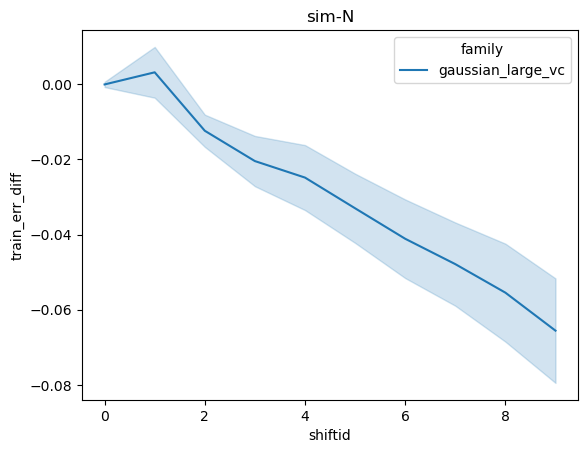

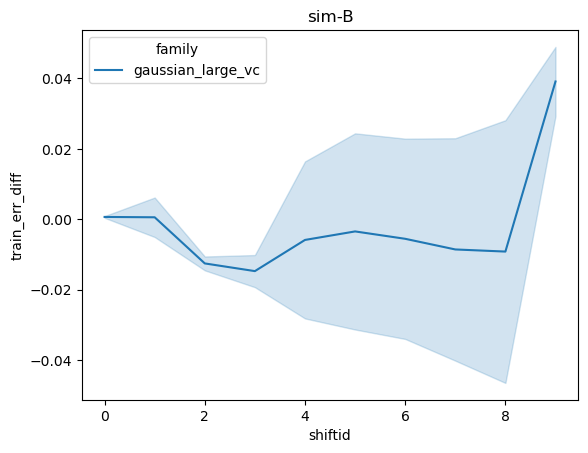

In [21]:
# make shiftid by train_err_diff plot
import seaborn as sns
import matplotlib.pyplot as plt

for d in dfd.dataset.unique():
    sdfd = dfd[dfd.dataset == d]
    sns.lineplot(
        data=sdfd,
        x="shiftid",
        y="train_err_diff",
        hue="family",
    )
    plt.title(d)
    plt.show()

In [22]:
# # make shiftid by train_err_diff plot
# import seaborn as sns
# import matplotlib.pyplot as plt

# for d in dfd.dataset.unique():
#     sdfd = dfd[dfd.dataset == d]
#     sns.lineplot(
#         data=sdfd,
#         x="shiftid",
#         y="test_err_diff",
#         hue="family",
#     )
#     plt.title(d)
#     plt.show()